In [19]:
import os
import copy
import torch
from torchvision import transforms
from  torchvision.ops import box_iou
from util.data_aug import *
from util.bbox_util import *
from util import joint_transforms as t
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import torchvision
from util.utils import box_iou
from util.actions_tree import Actor
import torch.nn.functional as F
from models.mnist_scale_model import Agent_ae
from models.cub_scale_model import Net
from datasets.cub_fewshot_std import CUB_fewshot
from RL_entropy import get_policy_loss
import matplotlib.ticker as ticker
from constants import IMAGENET_MEAN, IMAGENET_STD
from PIL import Image, ImageDraw

img_size = 224
num_cls = 14
batch_size = 5

os.environ['CUDA_VISIBLE_DEVICES']='3'

transform=t.Compose([
                              t.ConvertFromPIL(),
                              t.ToPercentCoords(),
                              t.Resize(224),
                              t.Normalize(IMAGENET_MEAN, IMAGENET_STD),
                              t.ToTensor()  # no change to (0, 1)
                          ])

def convert_image_np(inp, norm=True):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    if norm:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
    return inp


In [20]:
def init_dataloader():
    transform = t.Compose([
        t.ConvertFromPIL(),
        t.ToPercentCoords(),
        t.Resize(img_size),
        t.Normalize(IMAGENET_MEAN, IMAGENET_STD),
        t.ToTensor()  # no change to (0, 1)
    ])
    kwargs = {'num_workers': 0, 'pin_memory': True}
    trainset = CUB_fewshot('/research/cbim/vast/tl601/Dataset/CUB_200_2011',
                           mode='val', img_size=img_size,
                           transform=transform)
    train_loader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, **kwargs)
    print('total train image: ', len(train_loader.dataset))
    return train_loader


In [21]:
def init_model(hidden_size, pretrained, dim, freeze=1):
    net = Net(pooling_size=7, pretrained=True, dim=dim,
                      pooling_mode='align').to(device)
    agent = Agent_ae(rnn=1, dim_ag=512, poolsize=7,
                  num_class=14, hidden_size=hidden_size).to(device)
    # if load pretrained encoder
    ckpt = torch.load(os.path.join('/research/cbim/vast/tl601/results/'
                                       'mnist/', pretrained))
                     
    if 'state_dict' in ckpt.keys():
        mnist_pretrained_dict = ckpt['state_dict']
    else:
        mnist_pretrained_dict = ckpt
    embeddingnet_dict = net.state_dict()

    filtered_dict = {}
    for k, v in mnist_pretrained_dict.items():
        if k in embeddingnet_dict:
            filtered_dict[k] = v
    embeddingnet_dict.update(filtered_dict)
    net.load_state_dict(embeddingnet_dict)
    if 'state_dict' in ckpt.keys():
        print('loaded from {}\nckpt epoch {} acc inst {:.2f}%'.format(pretrained,
                                                ckpt['epoch'], ckpt['acc_inst']))
    else:
        print('loaded pretained MNIST encoder ', pretrained)

    if freeze == 1:
        for name, value in net.named_parameters():
            value.requires_grad = False

    return net, agent


In [22]:
hidden_size = 48
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader = init_dataloader()


val images 299 labels 5
total train image:  299


In [23]:
pretrained = 'pretrain_vgg_ord_cub_fewshot_lr1e03_spc5_cps5_img224_warbler_shufproto_warb15_dim1024_freezeall/last.pth.tar'
model, agent = init_model(hidden_size, pretrained, 1024)

# load model 
savename = 'ordinal_vgg_cub_seq10_ent05_lr1e03_stp80_shufprotshufprot_min40_warb15_dim1024freezeall'
saveroot = '/research/cbim/vast/tl601/results/selfpaced/ordinal/'
model_path = os.path.join(saveroot, savename, 'best.pth.tar')
print('loading ckpt from ', model_path)
ckpt = torch.load(model_path)
state_dict = ckpt['state_dict']
epoch = ckpt['epoch']
#best_loss = ckpt['acc']
agent.load_state_dict(state_dict)
print(("=> loaded checkpoint epoch {}".format(epoch)))#, best_loss)))

Loading pretrained weights from /research/cbim/vast/tl601/projects/selfpaced/vgg16_caffe.pth
loaded from pretrain_vgg_ord_cub_fewshot_lr1e03_spc5_cps5_img224_warbler_shufproto_warb15_dim1024_freezeall/last.pth.tar
ckpt epoch 149 acc inst 87.59%
loading ckpt from  /research/cbim/vast/tl601/results/selfpaced/ordinal/ordinal_vgg_cub_seq10_ent05_lr1e03_stp80_shufprotshufprot_min40_warb15_dim1024freezeall/best.pth.tar
=> loaded checkpoint epoch 139


/research/cbim/vast/tl601/anaconda3/envs/torch_ml/lib/python3.6/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


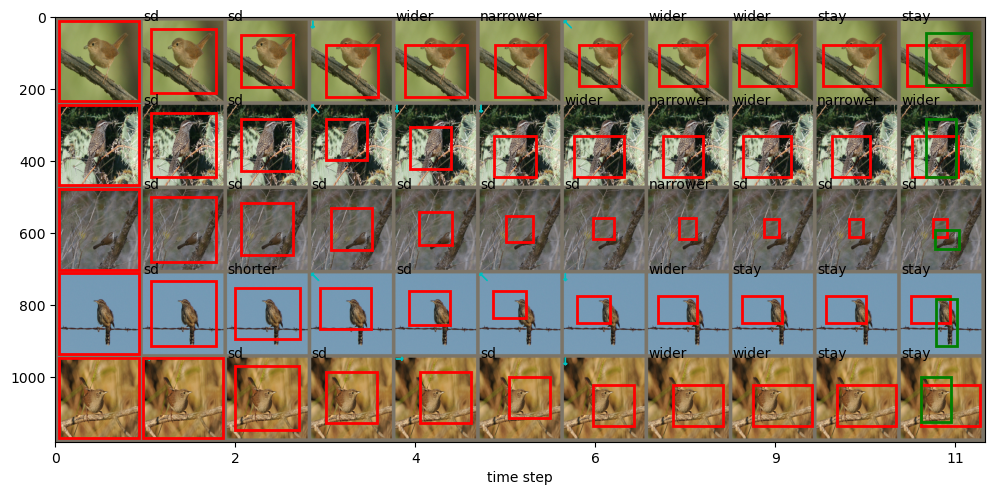

In [27]:
# compute embedding
supp_data, supp_target = train_loader.dataset.supp_data.to(device).clone(), \
                         train_loader.dataset.supp_targets.float().clone()
rois_t0 = torch.cat((torch.arange(0, supp_data.shape[0]).float().view(-1, 1),
                     supp_target), dim=1).to(device)
with torch.no_grad():
    supp_embed, supp_top_feat, _ = model(supp_data, rois_t0) # (support_size, 512)

proto_feat = torch.mean(supp_top_feat, dim=0) # (512,)

# visualize actions
torch.set_printoptions(precision=2, threshold=10000)
seq_len = 10
num = 5
with torch.no_grad():
    model.eval()
    agent.eval()
    data_org, target_org = next(iter(train_loader))
    #target_org = target_org[target_org[:, :, -1] == 3][:, :-1]
    data_org, target_org = data_org.to(device), target_org.to(device).float()
    data, target = data_org[:num], target_org[:num].clone()
    batch_size = data.shape[0]
    img = convert_image_np(torchvision.utils.make_grid(data.repeat(1, seq_len+1, 1, 1).view(num*(seq_len+1),
                                3, data.shape[2], data.shape[3]).cpu(), nrow=seq_len+1,
                                    padding=10), norm=True)

    fig = plt.figure(figsize=(12, 8), dpi= 100)
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(img)

    state = data.clone()
    all_embed = []
    logits_seq = []
    pred_boxes = torch.tensor([[0,0,img_size-1,img_size-1]]).float().repeat(batch_size, 1)
    boxes = [pred_boxes]
    rois = torch.cat((torch.arange(0, batch_size).float().view(-1, 1).to(device),
                          pred_boxes.to(device)), dim=1)
    org_boxes = pred_boxes.clone().to(device)
    
    action_seq = torch.IntTensor(batch_size, seq_len).to(device)
    rewards_supp_all = torch.zeros((batch_size, seq_len+1)).to(device)
    actor = Actor(data, min_box_side=40)
    if hidden_size:
        h_t = torch.zeros(
            batch_size,
            hidden_size,
            dtype=torch.float,
            device=device,
            requires_grad=True,
        )
    # 1st forward classifier
    with torch.no_grad():
        embed, top_feat = model.get_roi_embedding(rois)
    rewards_supp_all[:, 0] = F.pairwise_distance(proto_feat, top_feat)

    for t in range(seq_len):
        if hidden_size:
            h_t, logits, actions = agent(embed, h_t_prev=h_t)
        else:
            logits, actions = agent(embed)
            
        state, pred_boxes = actor.takeaction(actions)
        rois = torch.cat((torch.arange(0, batch_size).float().view(-1, 1).to(device),
                          pred_boxes.to(device)), dim=1)
        with torch.no_grad():
            embed, top_feat = model.get_roi_embedding(rois)
        all_embed.append(top_feat)
        action_seq[:, t] = actions.view(1, -1)
        logits_seq.append(logits)
        boxes.append(pred_boxes)
    
    pred_boxes_org = pred_boxes.clone().cpu()
    rewards_trns = F.pairwise_distance(proto_feat,
                                       torch.cat(all_embed))
    rewards_supp_all[:, 1:] = rewards_trns.view(-1, batch_size).permute(1,0)
    
    boxes_copy = copy.deepcopy(boxes)
    target_copy = copy.deepcopy(target)
    for t in range(len(boxes)):
        for i, b in enumerate(boxes[t][:num]): # (num ,4)
            change_y = i * (img_size+10) + 10
            change_x = t * (img_size+10) + 10
            b[1::2] += change_y # change y1, y2
            b[::2] += change_x     # 
            #print('t ', t, ' change_y ', change_y, ' change_x ', change_x)
            
            if t>0:
                if action_seq[i, t-1] == 0: #shrink towards TL
                    plt.arrow(change_x+20, change_y+20, -20, -20, length_includes_head=True, color='c',
                      head_width=10, head_length=4)
                elif action_seq[i,t-1] == 1: #shrink towards TR
                    plt.arrow(change_x, change_y+20, 20, -20, length_includes_head=True, color='c',
                      head_width=10, head_length=4)
                elif action_seq[i,t-1] == 2: #shrink toward bottom left
                    plt.arrow(change_x+20, change_y, -20, 20, length_includes_head=True, color='c',
                      head_width=10, head_length=4)
                elif action_seq[i,t-1] == 3: #shrink toward bottom right 
                    plt.arrow(change_x, change_y, 20, 20, length_includes_head=True, color='c',
                      head_width=10, head_length=4)
                elif action_seq[i,t-1] == 4: # scale down
                    plt.text(change_x, change_y, 'sd')
                elif action_seq[i,t-1] == 5: #stay 
                    plt.text(change_x, change_y, 'stay')
                elif action_seq[i,t-1] == 6: #left 
                    plt.arrow(change_x+20, change_y+3, -20, 0, length_includes_head=True, color='c',
                      head_width=10, head_length=4)
                elif action_seq[i,t-1] == 7: # right
                    plt.arrow(change_x, change_y+3, 20, 0, length_includes_head=True, color='c',
                      head_width=10, head_length=4)
                elif action_seq[i,t-1] == 8: # up
                    plt.arrow(change_x+3, change_y+20, 0, -20, length_includes_head=True, color='c',
                      head_width=10, head_length=4)
                elif action_seq[i,t-1] == 9: # down
                    plt.arrow(change_x+3, change_y, 0, 20, length_includes_head=True, color='c',
                      head_width=10, head_length=4)
                elif action_seq[i,t-1] == 10: # higher
                    plt.text(change_x, change_y, 'higher')
                elif action_seq[i,t-1] == 11: # wider
                    plt.text(change_x, change_y, 'wider')
                elif action_seq[i,t-1] == 12: # narrower
                    plt.text(change_x, change_y, 'narrower')
                elif action_seq[i,t-1] == 13: # shorter
                    plt.text(change_x, change_y, 'shorter')
            
    for i in range(target.shape[0]):
        target[i, 1::2] += i * (img_size+10) + 10
        target[i, ::2]  += seq_len * (img_size+10) + 10
    
    for box in boxes:
        for x1, y1, x2, y2 in box[:num]:
            patch = Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2,
                              edgecolor='r', facecolor='none', fill=False)
            ax.add_patch(patch)
            
    for x1, y1, x2, y2 in target:
        patch = Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2,
                              edgecolor='g', facecolor='none', fill=False)
        ax.add_patch(patch)
    
    ax.set_xlabel('time step')
    scale_x = img_size + 10
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x / scale_x))
    ax.xaxis.set_major_formatter(ticks_x)
    plt.show()

target_org  tensor([[ 19.19,  44.48, 191.85, 167.20],
        [ 17.02,  41.33, 182.78, 217.33],
        [ 51.52,  24.14, 185.02, 193.15],
        [ 35.84,  16.82, 179.65, 219.96],
        [ 33.67,  32.26, 191.27, 206.53]], device='cuda:0')
pred_boxes_org  tensor([[ 27.,  67., 165., 182.],
        [ 30.,  85., 158., 200.],
        [ 74.,  74., 114., 114.],
        [ 32.,  67., 120., 159.],
        [ 55.,  76., 220., 191.]])
0  iou  tensor(0.60)
1  iou  tensor(0.50)
2  iou  tensor(0.07)
3  iou  tensor(0.26)
4  iou  tensor(0.51)


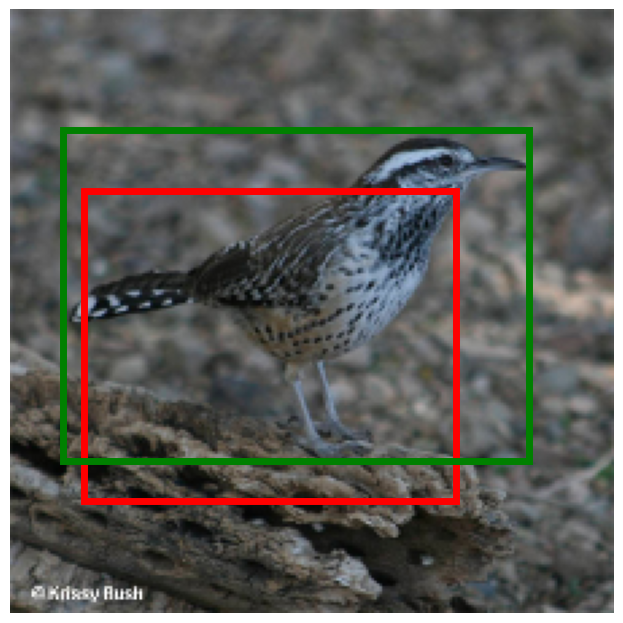

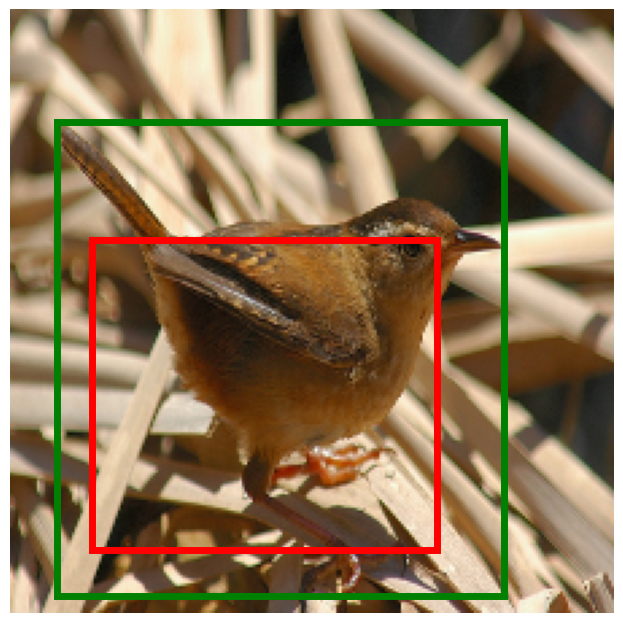

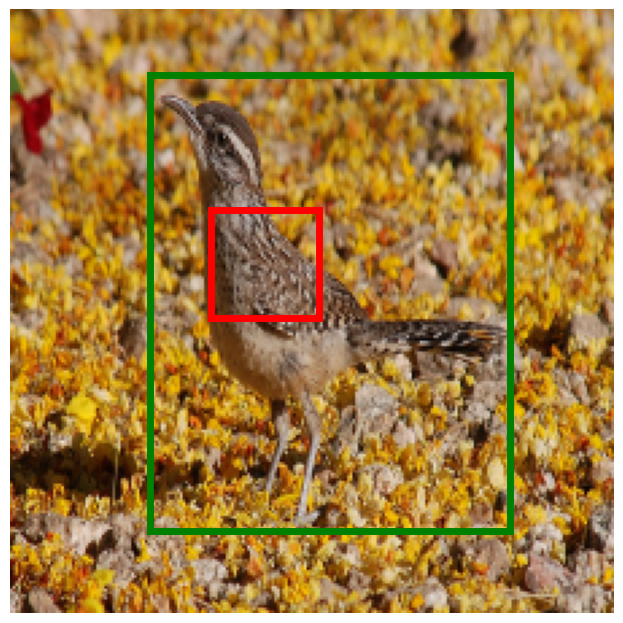

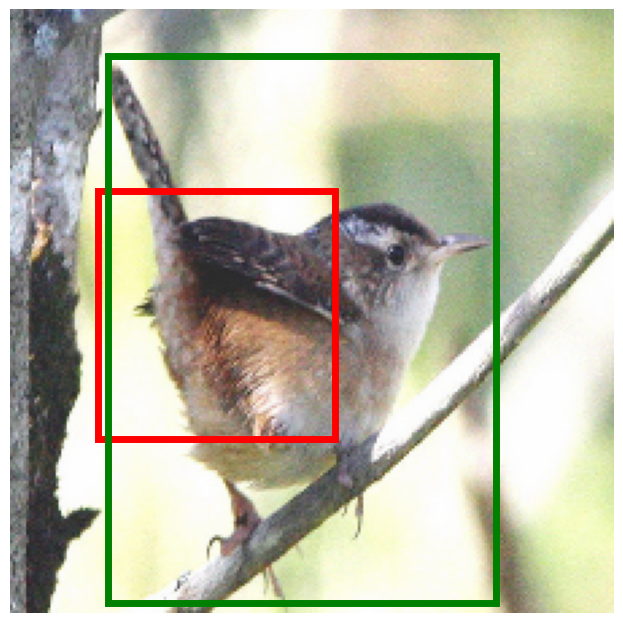

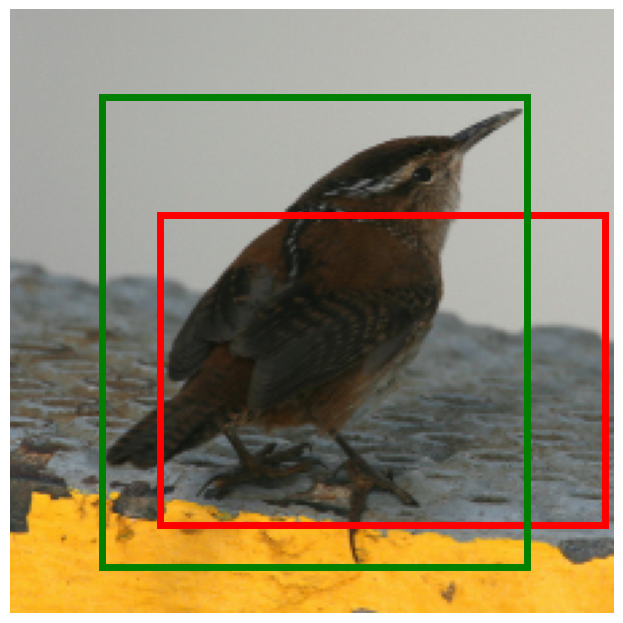

In [25]:
from util.utils import box_iou
ious = torch.diagonal(box_iou(target_org.cpu(), pred_boxes_org), 0)
print('target_org ', target_org)
print('pred_boxes_org ', pred_boxes_org)
for i in range(len(data)):
    
    print(i, ' iou ', ious[i])

    img = convert_image_np(data[i].cpu(), norm=True)

    fig = plt.figure(figsize=(12, 8), dpi= 100)
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(img)
    x1, y1, x2, y2 = pred_boxes_org.cpu()[i]
    patch = Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=5,
                      edgecolor='r', facecolor='none', fill=False)
    ax.add_patch(patch)
    x1, y1, x2, y2 = target_org[i]
    patch = Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=5,
                      edgecolor='g', facecolor='none', fill=False)
    ax.add_patch(patch)
    plt.axis('off')
    plt.savefig('loose{}_{:.2f}.png'.format(i, ious[i].item()), bbox_inches='tight', dpi=400)

rewards_supp_all  tensor([[112.65,  78.03,  78.03,  91.42,  73.19, 117.22,  87.48,  87.48,  87.48,
          87.48,  87.48],
        [118.34, 110.33, 123.55, 159.01, 113.16, 102.29,  91.97, 101.99,  91.34,
         101.98,  91.39],
        [347.57, 311.54, 296.10, 363.59, 374.96, 384.23, 388.46, 388.32, 387.45,
         387.45, 387.45],
        [225.54, 128.79,  88.53,  79.05, 135.22,  76.52,  88.29,  77.35,  77.35,
          77.35,  91.10],
        [142.60,  85.57,  69.67,  60.53,  73.39,  74.61,  67.14,  67.14,  67.14,
          64.68,  64.68]], device='cuda:0')


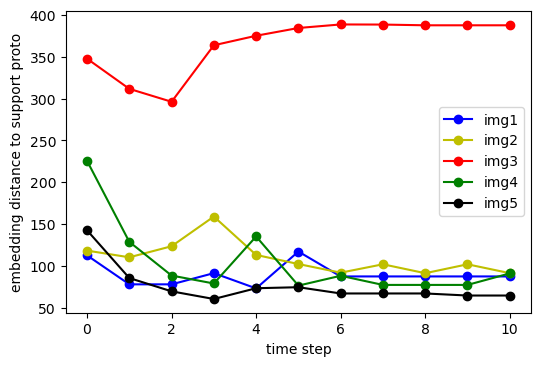

In [26]:
colors = ['b', 'y','r','g','k']
fig = plt.figure(dpi= 100)
ax = fig.add_subplot(1, 1, 1)
print('rewards_supp_all ', rewards_supp_all)
for i, r in enumerate(rewards_supp_all[:5].cpu().numpy()):
    plt.plot(range(seq_len+1), r, colors[i], label="img{}".format(i+1), marker='o')
plt.legend()
plt.xlabel('time step')
plt.ylabel('embedding distance to support proto')
plt.show()